#Part 1: Create a dependency(?) matrix across all participants

In [69]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import xlrd
import pickle
import seaborn as sb

%autosave 5

#import Alex-scored free recall sheets for story 43
xls43 = pd.ExcelFile('/Users/alexreblando/Documents/Baldassano Lab/43_Alex.xlsx')

#get sheet names
xls = xlrd.open_workbook(r'/Users/alexreblando/Documents/Baldassano Lab/43_Alex.xlsx', on_demand=True)
sheet_names = xls.sheet_names()

#import story stats in order to get story lengths
pickle_in = open("story_stats.pickle","rb")
story_stats = pickle.load(pickle_in)

#import story boundaries to get putative event boundaries
pickle_in = open("story_boundaries.pickle","rb")
story_boundaries = pickle.load(pickle_in)

#import subj_schemas matrix so that for each story for each subject you can know if they are
#social or location primed
pickle_in = open("subj_schemas.pickle","rb")
subj_schemas = pickle.load(pickle_in)

Autosaving every 5 seconds


Part 1: Create a dependency(?) matrix between the sentences of the story based on their
mentions in the free recall across all participants
#Step 1:Put the scored sheet of each participant in a new entry of a dictionary
#Step 2:Make a participant x story sentences matrix with '1' values for sentences that that 
participant mentioned in their free recall
#Step 3:Make the dependency matrix 

In [3]:
##Step 1:put the scored sheet of each participant in a new entry of a dictionary

rs_dict = {}

for name in sheet_names:
    rs_dict[name] = pd.read_excel(xls43, name)

In [57]:
##Step 2:make a participant x story sentences matrix with '1' values for sentences that that 
#participant mentioned in their free recall

#find the number of sentences in story 43
n_sent = story_stats['43'][3]
subj_sent_m = np.zeros((len(sheet_names), n_sent))
count = 0

for name in sheet_names:
    for i in range(n_sent):
        val = np.sum(rs_dict[name][i+1])
        if val > 0:
            val = 1
        subj_sent_m[count, i] = val
    count += 1

In [68]:
sheet_names

['091619_p1',
 '091819_p2',
 '092319_p1',
 '092319_p2',
 '092319_p3',
 '092419_p1',
 '100419_p1',
 '100719_p2',
 '101019_p1',
 '111319_p1',
 '111919_p1',
 '111919_p2',
 '112019_p1']

In [58]:
##Step 3: Make the dependency matrix, which is a sentence by sentence matrix
#where the probability of sentence x and sentence y being recalled together is divided by
#the probability of just sentence x being recalled times the probability of just sentence y
#being recalled.
##Part 1: Make the matrix P(Senti and sent j)/(P(Senti) * P(Sentj))
##Part 2: Make the matrix of just the counts of co occurrences of sentence mentions
##Part 3: Create the null dependency matrix where null_dep_matrix[i,j] = dep_matrix[i,i] * dep_matrix[j,j]
##Part 4.1: Import the putative event boundaries for story 43

/Users/alexreblando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning:

invalid value encountered in double_scalars



0.07692307692307693 0.07692307692307693
0.07692307692307693
13.0


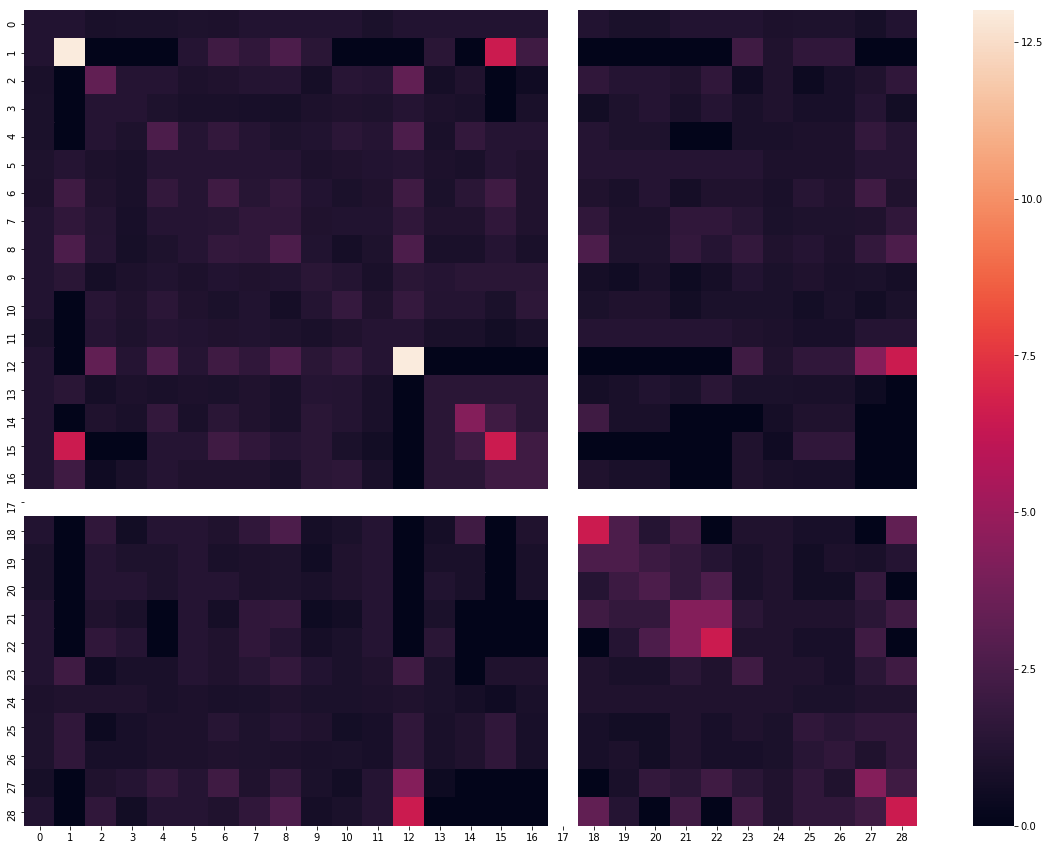

In [65]:
##Part 1: Make the matrix P(Senti and sent j)/(P(Senti) * P(Sentj))

#make the empty sentence x sentence matrix
norm_dep_matrix = np.zeros((sents,sents))

subj, sents = subj_sent_m.shape

for i in range(sents):
    for j in range(sents):
        first_prob = np.sum(subj_sent_m[:, i])/subj
        second_prob = np.sum(subj_sent_m[:, j])/subj
        if i == 1 and j == 1:
            print(first_prob, second_prob)
        count = 0
        for k in range(subj):
            if subj_sent_m[k, i] == 1:
                if subj_sent_m[k, j] == 1:
                    count += 1
        first_second_prob = count/subj
        if i == 1 and j == 1:
            print(first_second_prob)
            print(first_second_prob/(first_prob * second_prob))
        norm_dep_matrix[i, j] = first_second_prob/(first_prob * second_prob)
        
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(norm_dep_matrix)
#heatmap = sb.heatmap(dep_matrix, vmin=0, vmax=2)
plt.show()

1.0 1.0


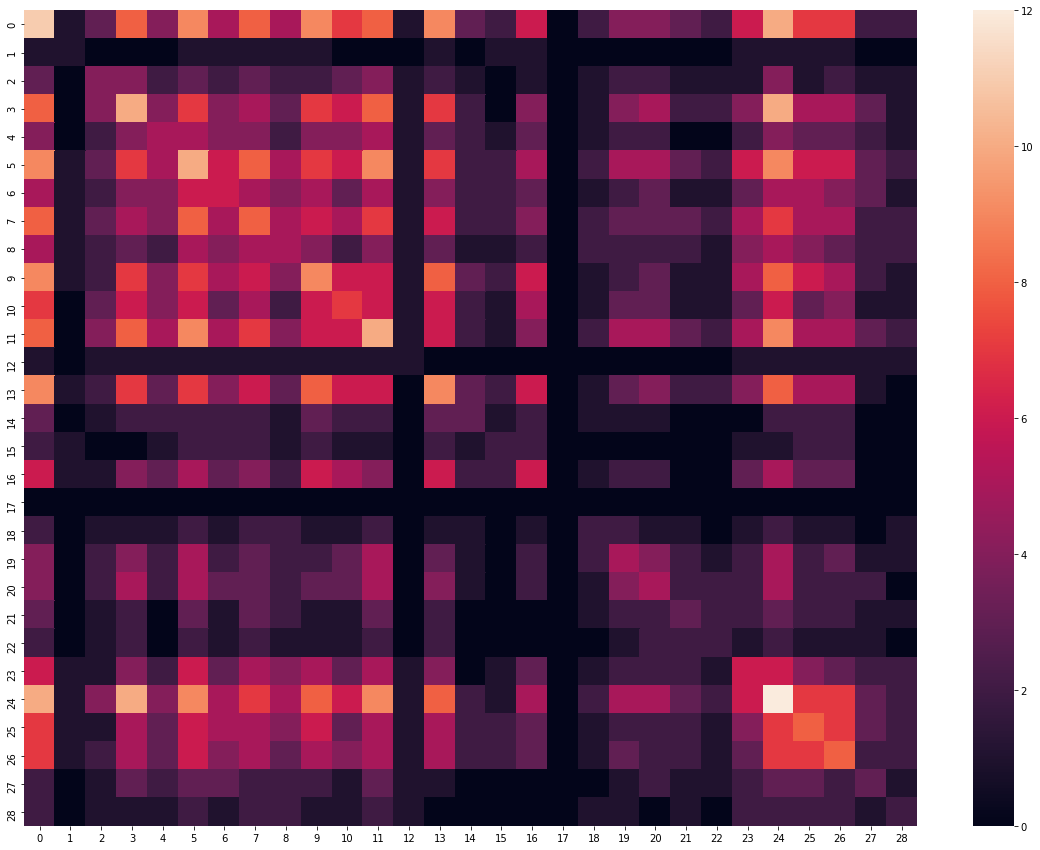

In [66]:
##Part 2: Make the matrix of just the counts of co occurrences of sentence mentions

#make the empty sentence x sentence matrix
dep_matrix = np.zeros((sents,sents))

for i in range(sents):
    for j in range(sents):
        first_prob = np.sum(subj_sent_m[:, i])
        second_prob = np.sum(subj_sent_m[:, j])
        if i == 1 and j == 1:
            print(first_prob, second_prob)
        count = 0
        for k in range(subj):
            if subj_sent_m[k, i] == 1:
                if subj_sent_m[k, j] == 1:
                    count += 1
        first_second_prob = count
        dep_matrix[i, j] = first_second_prob
        
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(dep_matrix)
plt.show()

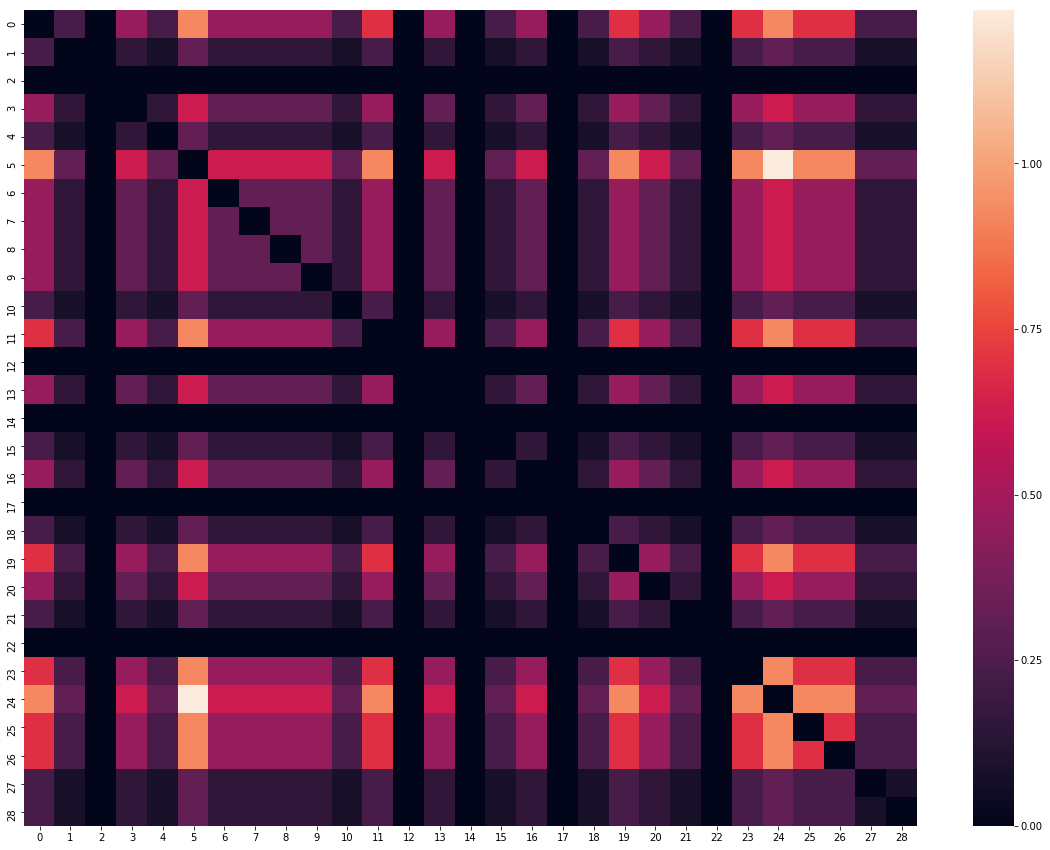

In [99]:
##Part 3: Create the null dependency matrix where null_dep_matrix[i,j] = dep_matrix[i,i] * dep_matrix[j,j]

null_dep_matrix = np.zeros((sents, sents))
for i in range(sents):
    for j in range(i+1, sents):
        ##why am i dividing by subjects?
        null_dep_matrix[i,j] = dep_matrix[i,i] * dep_matrix[j,j]/subj
null_dep_matrix = null_dep_matrix + null_dep_matrix.T
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(null_dep_matrix)
plt.show()

In [88]:
#Part 4: SOCIAL PRIMED PARTICIPANTS

##Step 2:make a participant x story sentence matrix with '1' values for sentences that that 
#participant mentioned in their free recall for social primed participants

#find the number of sentences in story 43
n_sent = story_stats['43'][3]

#the number of social primed participants
n_social = (sum( x == 'Social' for x in subj_schemas['43'].values()))

#make empty participant x story sentences matrix
soc_subj_sent_m = np.zeros((n_social, n_sent))
count = 0
for name in sheet_names:
    if subj_schemas['43'][name] == 'Social':
        for i in range(n_sent):
            val = np.sum(rs_dict[name][i+1])
            if val > 0:
                val = 1
            soc_subj_sent_m[count, i] = val
        count += 1


1.0 1.0


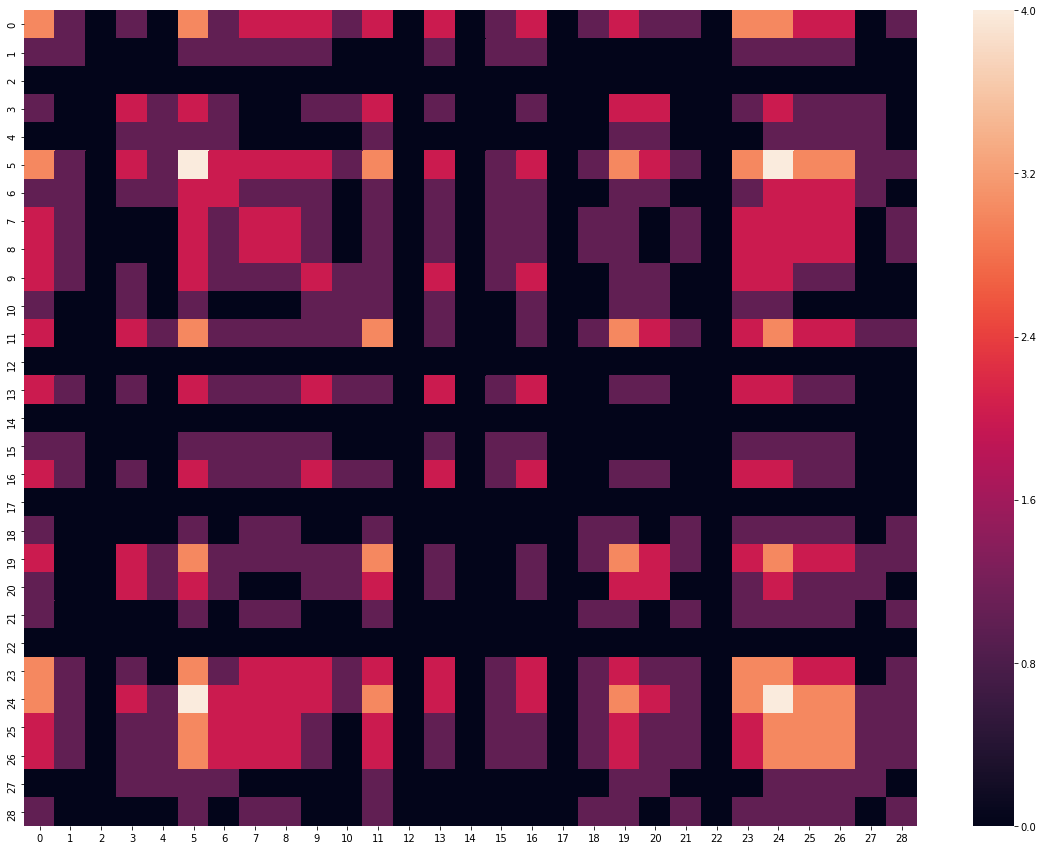

In [95]:
#Part 4.1: Make the co occurrence count of social primed participants

#make the empty sentence x sentence matrix
soc_dep_matrix = np.zeros((sents,sents))

for i in range(sents):
    for j in range(sents):
        first_prob = np.sum(subj_sent_m[:, i])
        second_prob = np.sum(subj_sent_m[:, j])
        if i == 1 and j == 1:
            print(first_prob, second_prob)
        count = 0
        for k in range(n_social):
            if subj_sent_m[k, i] == 1:
                if subj_sent_m[k, j] == 1:
                    count += 1
        first_second_prob = count
        soc_dep_matrix[i, j] = first_second_prob
        
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(soc_dep_matrix)
plt.show()

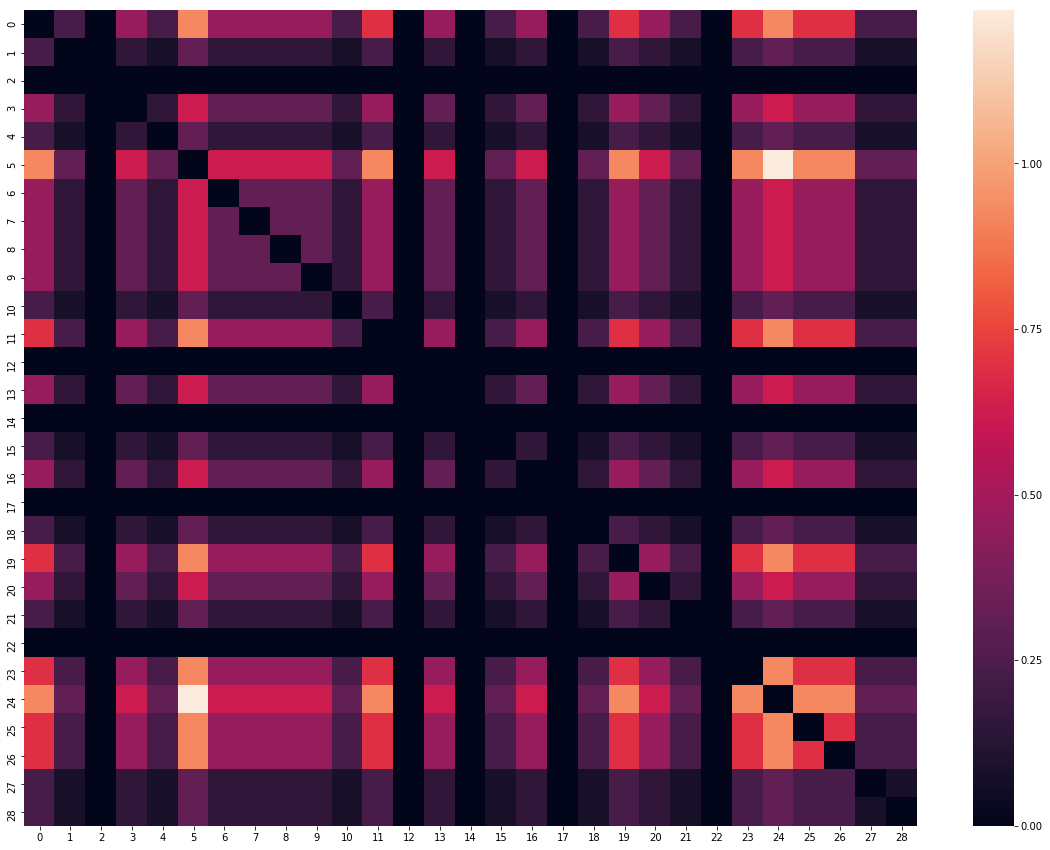

In [97]:
#Part 4.2 Make the null dependency matrix for social primed responses
soc_null_dep_matrix = np.zeros((sents, sents))
for i in range(sents):
    for j in range(i+1, sents):
        soc_null_dep_matrix[i,j] = soc_dep_matrix[i,i] * soc_dep_matrix[j,j]/subj
soc_null_dep_matrix = soc_null_dep_matrix + soc_null_dep_matrix.T
plt.subplots(figsize=(20,15))
heatmap = sb.heatmap(soc_null_dep_matrix)
plt.show()

In [126]:
#4.3: SOCIAL PRIMED PARTICIPANTS PARCED INTO SOCIAL EVENTS:
#divide the co occurence matrix and the null dependency matrix into the SOCIAL events

#find the story sentences that mark the boundaries of each social event
event = {}

count = 1
for i in range(1, 5):    
    event[i] = np.zeros((1,2))
    for j in range(len(story_boundaries['43'])):
        if story_boundaries['43'][j, 1] == 1:
            event[i][0,0] = j
            if count == 1:
                count +=1
            else:
                print(event)
                event[i-1][0,1] = j-1
                count +=1
        
    

{1: array([[5., 0.]])}


KeyError: 0

In [110]:
event1[0,1] =1
print(event1)

[[0. 1.]]


In [112]:
len(story_boundaries['43'])

29

In [114]:
story_boundaries['43'][:,1]

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0])

In [116]:
story_boundaries['43'][,1]

0